In [101]:
using DifferentialEquations, StaticArrays, StatsBase, Plots

In [102]:
### Callback for left wall
function left_wall(out, u, t, integrator)
    r = integrator.p.r

    @. out[:] = u[:, 1] - r
end

function right_wall(out, u, t, integrator)
    r = integrator.p.r

    @. out[:] = u[:, 1] - 1.0 + r
end

function bottom_wall(out, u, t, integrator)
    r = integrator.p.r
    
    @. out[:] == u[:, 2] - r
end

function top_wall(out, u, t, integrator)
    r = integrator.p.r

    @. out[:] == u[:, 2] - 1.0 + r
end

function vertical_wall_collide!(integrator, idx)
    ξ = integrator.p.ξ
    integrator.u[idx, 3] *= -ξ
    integrator.u[idx, 4] *= ξ
    return nothing
end

function horizontal_wall_collide!(integrator, idx)
    ξ = integrator.p.ξ
    integrator.u[idx, 3] *= ξ
    integrator.u[idx, 4] *= -ξ
    return nothing
end

horizontal_wall_collide! (generic function with 2 methods)

In [116]:
# Define the function
function f!(unp1,un,p,t)
    unp1[:,1] .= un[:,3]
    unp1[:,2] .= un[:,4]
    # dun[:,3] .= 0.0
    # dun[:,4] .= 0.0
    # integrator.dt = calc_dt()
    dt_step_control!(integrator)
    
    return nothing
end

function dt_step_control!(integrator)
    # Set the dt in the integrator to the minimum dt
    # Find minimum time to collision in x
    x = @view integrator.u[:, 1]
    y = @view integrator.u[:, 2]
    
    vx = @view integrator.u[:, 3]
    vy = @view integrator.u[:, 4]

    dts_x = similar(x)
    dts_y = similar(y)

    r = integrator.p.r


    case = vx .> 0.0
    dts_x[case] = (1.0 .- r[case] - x[case]) ./ vx[case]

    case .= vx .< 0.0
    case .= vx .== 0.0


    dts_x[case2] = (r[case2] - x[case2]) ./ vx[case2]
    dts_x[case3] = Inf

    # Find minimum time to collision in y
    case1 = u[:, 4] .> 0.0
    case2 = u[:, 4] .< 0.0
    case3 = u[:, 4] .== 0.0

    dts_y[case1] = (1.0 .- r[case1] - y[case1]) ./ vy[case1]
    dts_y[case2] = (r[case2] - y[case2]) ./ vy[case2]
    dts_y[case3] = Inf

    # Set integrator dt to the minimum of the two
    integrator.dt = min(minimum(dts_x), minimum(dts_y))

end

dt_step_control! (generic function with 1 method)

In [117]:
N = 100
save_coll = true
cbs = CallbackSet(
    VectorContinuousCallback(left_wall, vertical_wall_collide!, N; save_positions=(save_coll,save_coll)),
    VectorContinuousCallback(right_wall, vertical_wall_collide!, N; save_positions=(save_coll,save_coll)),
    VectorContinuousCallback(bottom_wall, horizontal_wall_collide!, N; save_positions=(save_coll,save_coll)),
    VectorContinuousCallback(top_wall, horizontal_wall_collide!, N; save_positions=(save_coll,save_coll))
    )



# Define the initial condition
m = hcat(0.0:0.001:1.0, 0.0:0.001:1.0) 
r = 0.01
display(size(m))
rs = sample(m,(N,2), replace=false)
vs = sample(-1.0+r:0.01:1.0-r,(N,2))
u0 = hcat(rs,vs)


# Define the time span
tspan = (0.0,1.0)
radii = fill(r,N)
ξ = 1.0
dts = fill(0.0, N)
p = (N = N, ξ = ξ, r=radii, dts=dts)
# Define a discrete problem
prob = DiscreteProblem(f!,u0,tspan,p)
integrator = init(prob, FunctionMap{true}(), callback=cbs)

t = 0.0
while t < tspan[2]
    dt_step_control!(integrator)
    step!(integrator)
end






(1001, 2)

LoadError: UndefVarError: case1 not defined

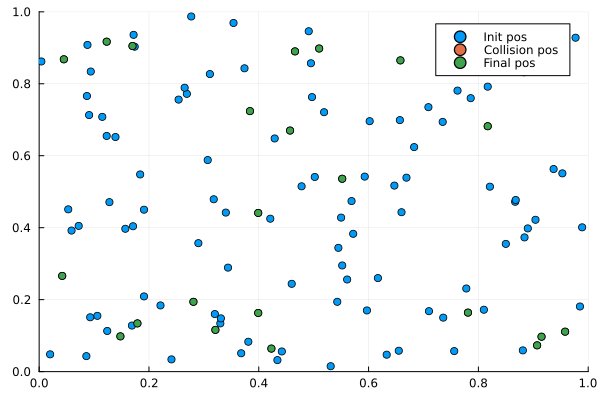

In [82]:
scatter(sol[1][:,1],sol[1][:,2], ylims = (0.0, 1.0), xlims=(0.0,1.0), label="Init pos")
scatter!(sol[2][:,1],sol[2][:,2], ylims = (0.0, 1.0), xlims=(0.0,1.0), label="Collision pos")
scatter!(sol[end][:,1],sol[end][:,2], ylims = (0.0, 1.0), xlims=(0.0,1.0), label="Final pos")
